## Pitch Prediction - Exploratory Data Analysis

The goal of this project is to build a model to predict what pitch a pitcher will throw next. Before building the model, however, I'm going to do some exploratory data analysis to get a sense for what the biggest predictors will be. 

In [1]:
#Import required packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Load csv and check top 5 rows

csv_path = '2017_pitchfx.csv'
df = pd.read_csv(csv_path)
df.head()

,pitcher_name,batter_name,stand,p_throws,inning_side,count,x,y,pitch_type,type_confidence,on_1b,on_2b,on_3b,num,event_num,gameday_link,b,s
0,Christopher Archer,Brett Gardner,L,R,top,0-0,78.78,203.77,FF,2.0,0.0,0.0,0.0,1.0,3,gid_2017_04_02_nyamlb_tbamlb_1,0,0
1,Christopher Archer,Brett Gardner,L,R,top,1-0,111.67,159.76,FF,2.0,0.0,0.0,0.0,1.0,4,gid_2017_04_02_nyamlb_tbamlb_1,1,0
2,Christopher Archer,Brett Gardner,L,R,top,1-1,153.12,160.97,FF,2.0,0.0,0.0,0.0,1.0,5,gid_2017_04_02_nyamlb_tbamlb_1,1,1
3,Christopher Archer,Brett Gardner,L,R,top,2-1,148.28,162.52,FF,2.0,0.0,0.0,0.0,1.0,6,gid_2017_04_02_nyamlb_tbamlb_1,2,1
4,Christopher Archer,Brett Gardner,L,R,top,2-2,87.08,194.67,SL,2.0,0.0,0.0,0.0,1.0,7,gid_2017_04_02_nyamlb_tbamlb_1,2,2


### Corey Kluber's Pitch Selection

I'll use Indian's ace Corey Kluber as my example

In [3]:
def filter_pitcher(data, pitcher_name):
    filtered = data[data['pitcher_name'] == pitcher_name]
    return filtered

kluber = filter_pitcher(df, 'Corey Kluber')
kluber.head()

,pitcher_name,batter_name,stand,p_throws,inning_side,count,x,y,pitch_type,type_confidence,on_1b,on_2b,on_3b,num,event_num,gameday_link,b,s
3167,Corey Kluber,Carlos Gomez,R,R,bottom,0-0,127.39,141.47,SI,2.0,0.0,0.0,0.0,5.0,35,gid_2017_04_03_clemlb_texmlb_1,0,0
3168,Corey Kluber,Carlos Gomez,R,R,bottom,1-0,81.85,191.16,SI,2.0,0.0,0.0,0.0,5.0,36,gid_2017_04_03_clemlb_texmlb_1,1,0
3169,Corey Kluber,Carlos Gomez,R,R,bottom,1-1,107.30,158.50,FC,2.0,0.0,0.0,0.0,5.0,37,gid_2017_04_03_clemlb_texmlb_1,1,1
3170,Corey Kluber,Carlos Gomez,R,R,bottom,1-2,87.38,116.71,FF,2.0,0.0,0.0,0.0,5.0,38,gid_2017_04_03_clemlb_texmlb_1,1,2
3171,Corey Kluber,Carlos Gomez,R,R,bottom,2-2,72.14,163.70,SI,2.0,0.0,0.0,0.0,5.0,39,gid_2017_04_03_clemlb_texmlb_1,2,2


### Times Through Order

Another variable I'd like to consider is time-through-order. A pitcher has incentive to change his pitch selection or sequencing each additional time he faces a batter to prevent the batter from recognizing patterns. This was a difficult column to create in the database containing all pitchers, but now that I've filtered to just one it should be pretty straight forward. 

In [4]:
#Compute times through the order

def compute_tto(pitcher_data):
    pitcher_data['TTO'] = np.zeros(len(pitcher_data))
    active_game = pitcher_data['gameday_link'].iloc[0]
    active_ab = pitcher_data['num'].iloc[0]
    ab = 1
    tto = 1
    for i in range(len(pitcher_data)):
        current_game = pitcher_data['gameday_link'].iloc[i]
        current_ab = pitcher_data['num'].iloc[i]
        if (current_game != active_game):
            active_game = current_game
            ab = 1
            tto = 1
            pitcher_data['TTO'].iloc[i] = tto
        elif (current_ab != active_ab):
            active_ab = current_ab
            ab += 1
            if (ab <= 9):
                pitcher_data['TTO'].iloc[i] = tto
            elif (ab <= 18):
                tto = 2
                pitcher_data['TTO'].iloc[i] = tto
            else: 
                tto = 3
                pitcher_data['TTO'].iloc[i] = tto
        else:
            pitcher_data['TTO'].iloc[i] = tto
    return pitcher_data

kluber = compute_tto(kluber)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21

### Previous Pitch Thrown

Another variable I want is the previous pitch thrown.

In [5]:
#Get previous pitch thrown in AB

def prev_pitch(pitcher_data):
    pitcher_data['prev_pitch'] = np.zeros(len(pitcher_data))
    for i in range(len(pitcher_data)):
        if pitcher_data['count'].iloc[i] == '0-0':
            pitcher_data['prev_pitch'].iloc[i] = 'First Pitch'
        else:
            pitcher_data['prev_pitch'].iloc[i] = pitcher_data['pitch_type'].iloc[i-1]
    return pitcher_data

kluber = prev_pitch(kluber)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: 

Now that I have all of the variables I need, I no longer care about 'gameday_link', 'num', or 'event_num', so I'll drop those columns.

In [6]:
kluber.drop(['gameday_link','num','event_num'], axis = 1, inplace = True)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [7]:
kluber.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2936 entries, 3167 to 699053
Data columns (total 17 columns):
pitcher_name       2936 non-null object
batter_name        2936 non-null object
stand              2936 non-null object
p_throws           2936 non-null object
inning_side        2936 non-null object
count              2936 non-null object
x                  2936 non-null float64
y                  2936 non-null float64
pitch_type         2936 non-null object
type_confidence    2936 non-null float64
on_1b              2936 non-null float64
on_2b              2936 non-null float64
on_3b              2936 non-null float64
b                  2936 non-null int64
s                  2936 non-null int64
TTO                2936 non-null float64
prev_pitch         2936 non-null object
dtypes: float64(7), int64(2), object(8)
memory usage: 412.9+ KB


First I want to look at Kluber's pitch arsenal to make sure he throws enough pitches to warrant this analysis. A pitcher that only throws two pitches, for example, would make this exercise less interesting. 

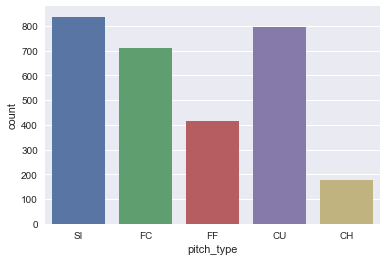

In [8]:
def plot_pitch_dist(data):
    sns.countplot(data['pitch_type'])
    
plot_pitch_dist(kluber)


We see that Kluber throws 5 pitches, perfect! Per [Fangraphs](https://www.fangraphs.com/library/pitch-type-abbreviations-classifications/), here are the pitches the PitchF/x abbreviations correspond to:

- SI: Sinker
- FC: Cut fastball
- FF: Four-seam fastball
- CU: Curveball
- CH: Changeup

Let's see how his pitch selection breaks down by batter handedness

In [16]:
def pitch_splits(df, split_by = None):
    '''
    Creates a pitch type proportion table based on given split_arg.
    Split args can be:
    - 'stand': batter handedness
    - 'count': count in at bat
    - 'b': number of balls
    - 's': number of strikes
    - 'on_1b': Man on 1st or not
    - 'on_2b': Man on 2nd or not
    - 'on_3b': Man on 3rd or not
    '''
    if (split_by is not None):
        splits = pd.crosstab(index = df['pitch_type'], columns = df[split_by], normalize = 'columns')
    else:
        splits = pd.crosstab(index = df['pitch_type'], columns = 'percentage', normalize = 'columns')
    return splits
    
pitch_splits(kluber, 'stand')

stand,L,R
pitch_type,,
CH,0.121060,0.004545
CU,0.231375,0.307792
FC,0.205587,0.275325
FF,0.164756,0.120130
SI,0.277221,0.292208


We can see Kluber almost never throws his changeup to righties, instead favoring his curveball and cut fastball. Let's now visualize this data from the view of the umpire. 

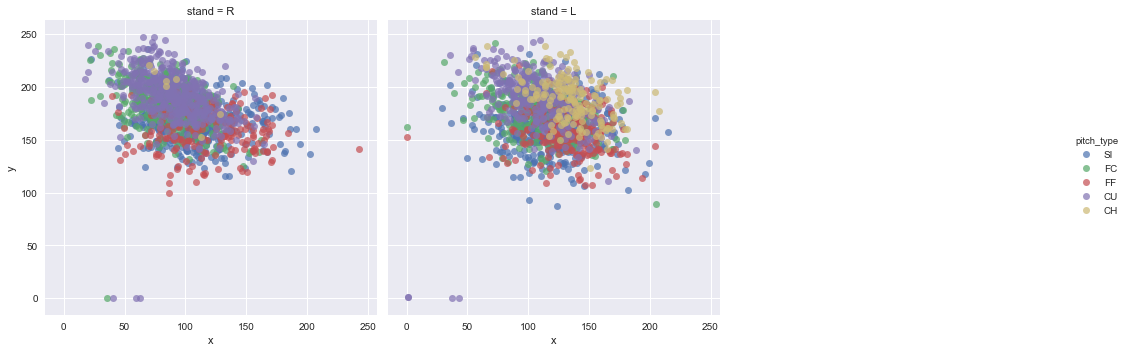

In [23]:
def plot_splits_loc(data, split_arg):
    '''
    Creates plots for of pitch type and location based on given split_arg. 
    Split args can be:
    - 'stand': batter handedness
    - 'count': count in at bat
    - 'b': number of balls
    - 's': number of strikes
    - 'on_1b': Man on 1st or not
    - 'on_2b': Man on 2nd or not
    - 'on_3b': Man on 3rd or not
    '''
    sns.lmplot(x = 'x', y = 'y', data = data, fit_reg = False, hue = 'pitch_type', 
               scatter_kws = {'alpha':0.7}, col = split_arg, col_wrap = 3)
    
plot_splits_loc(kluber, 'stand')    

Let's take a look at how Kluber varies his pitches by number of balls and strikes

In [18]:
pitch_splits(kluber, 's')

s,0,1,2
pitch_type,,,
CH,0.052356,0.098398,0.032751
CU,0.169284,0.262014,0.408297
FC,0.290576,0.240275,0.183406
FF,0.146597,0.131579,0.144105
SI,0.341187,0.267735,0.231441


In [19]:
pitch_splits(kluber, 'b')

b,0,1,2,3
pitch_type,,,,
CH,0.067893,0.072142,0.030733,0.010101
CU,0.260255,0.310766,0.300236,0.111111
FC,0.239038,0.219756,0.255319,0.338384
FF,0.150636,0.118757,0.148936,0.161616
SI,0.282178,0.278579,0.264775,0.378788


In [20]:
#Okay, let's take a look at pitch type by prev pitch thrown
pitch_splits(kluber, 'prev_pitch')

prev_pitch,CH,CU,FC,FF,First Pitch,SI
pitch_type,,,,,,
CH,0.054688,0.047794,0.075000,0.075758,0.049096,0.064062
CU,0.203125,0.325368,0.276923,0.342424,0.197674,0.287500
FC,0.257812,0.237132,0.148077,0.230303,0.298450,0.257812
FF,0.140625,0.163603,0.163462,0.118182,0.147287,0.109375
SI,0.343750,0.226103,0.336538,0.233333,0.307494,0.281250


In [21]:
pitch_splits(kluber, 'TTO')

TTO,1.0,2.0,3.0
pitch_type,,,
CH,0.051780,0.063025,0.064333
CU,0.222222,0.296218,0.292337
FC,0.229773,0.243697,0.251656
FF,0.172600,0.120798,0.132450
SI,0.323625,0.276261,0.259224


In [22]:
#Write data to CSV for modeling
kluber.to_csv('kluber.csv', index = False)